## 1.DataSet: Bounding Box

> 1.Store Image and Image Mask GT path instead of loading it to the notebook to avoid RAM Crash

> 2.Extract the bounding box of an object in the image by utilizing the images Mask GT

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

# 1. Download Dataset
path = kagglehub.dataset_download("crowww/a-large-scale-fish-dataset")
base_dir = os.path.join(path, "Fish_Dataset", "Fish_Dataset")

print(f"Dataset downloaded to: {base_dir}")

# 2. Initialize list to store metadata
dataset_records = []

# 3. Iterate through folders
print("Processing metadata and bounding boxes...")

for species in os.listdir(base_dir):
    species_path = os.path.join(base_dir, species)

    # Check if it's a directory
    if not os.path.isdir(species_path):
        continue

    # The dataset structure  has two folders per species:
    # 1. "SpeciesName" (Images)
    # 2. "SpeciesName GT" (Masks)

    image_folder = os.path.join(species_path, species)
    gt_folder = os.path.join(species_path, f"{species} GT")

    # Ensure both exist
    if not os.path.exists(image_folder) or not os.path.exists(gt_folder):
        continue

    # Loop through images in the image folder
    for img_file in os.listdir(image_folder):
        if img_file.lower().endswith((".png", ".jpg", ".jpeg")):

            # Define Paths
            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(gt_folder, img_file)


            # If exact match not found, check extension variants if necessary.
            if not os.path.exists(mask_path):
                # Try replacing extension if needed, usually this dataset matches names
                continue

            # OPTIMIZATION: OPEN MASK JUST TO GET BOX THEN DISCARD
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Calculate Bounding Box
            ys, xs = np.where(mask > 0)
            if len(xs) > 0:
                xmin, xmax = xs.min(), xs.max()
                ymin, ymax = ys.min(), ys.max()
                # Store metadata
                dataset_records.append({
                    'species': species,
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'xmin': xmin, 'ymin': ymin,
                    'xmax': xmax, 'ymax': ymax,
                    'has_fish': True
                })
            else:
                # Empty mask (no fish in image)
                dataset_records.append({
                    'species': species,
                    'image_path': img_path,
                    'mask_path': mask_path,
                    'xmin': 0, 'ymin': 0, 'xmax': 0, 'ymax': 0,
                    'has_fish': False
                })

# 4. Convert to DataFrame
df = pd.DataFrame(dataset_records)

print("--- Processing Complete ---")
print(f"Total images processed: {len(df)}")
print(df.head())

100%|██████████| 3.24G/3.24G [00:31<00:00, 110MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/crowww/a-large-scale-fish-dataset/versions/2/Fish_Dataset/Fish_Dataset
Processing metadata and bounding boxes...
--- Processing Complete ---
Total images processed: 9000
           species                                         image_path  \
0  Gilt-Head Bream  /root/.cache/kagglehub/datasets/crowww/a-large...   
1  Gilt-Head Bream  /root/.cache/kagglehub/datasets/crowww/a-large...   
2  Gilt-Head Bream  /root/.cache/kagglehub/datasets/crowww/a-large...   
3  Gilt-Head Bream  /root/.cache/kagglehub/datasets/crowww/a-large...   
4  Gilt-Head Bream  /root/.cache/kagglehub/datasets/crowww/a-large...   

                                           mask_path  xmin  ymin  xmax  ymax  \
0  /root/.cache/kagglehub/datasets/crowww/a-large...   136    41   480   444   
1  /root/.cache/kagglehub/datasets/crowww/a-large...    19   122   542   331   
2  /root/.cache/kagglehub/datasets/crowww/a-large...    27    62   580   306   
3  /root/.cache/

-----

### 2\. Visualize Bounding box in image



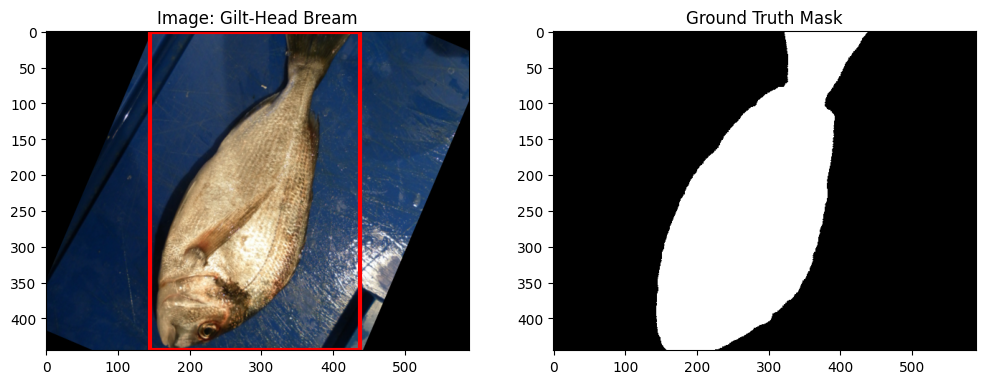

In [2]:
# Pick a random image
sample = df[df['has_fish'] == True].sample(1).iloc[0]

# Load data
img = cv2.imread(sample['image_path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

xmin, ymin, xmax, ymax = sample['xmin'], sample['ymin'], sample['xmax'], sample['ymax']

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Image with Box
ax[0].imshow(img)
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     linewidth=3, edgecolor='red', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title(f"Image: {sample['species']}")

# Mask
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Ground Truth Mask")

plt.show()

# Preprocess dataset
- Encode dataset
- Split Data
- convert Box to YOLO format

In [3]:
import os
import shutil
import yaml
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  # Progress bar

# 1. Define YOLO Directory Structure
output_dir = "yolo_dataset"
images_dir = os.path.join(output_dir, "images")
labels_dir = os.path.join(output_dir, "labels")

# Create folders: images/train, images/test, labels/train, labels/test
for split in ['train', 'test']:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# 2. Encode Classes (String -> Int)
classes = df['species'].unique().tolist()
class_map = {name: i for i, name in enumerate(classes)}

print("Class mapping:", class_map)

# 3. Split Data (80% Train, 20% Test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['species'])

# Function to convert Box to YOLO format
def process_dataset(dataframe, split_name):
    print(f"Processing {split_name} data...")

    for index, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        # Skip if no fish (optional, but YOLO can train on background images too)
        #if not row['has_fish']:
           # continue

        # Source Paths
        img_src = row['image_path']
        filename = os.path.basename(img_src)
        name_only = os.path.splitext(filename)[0]

        # Read Image Dimensions
        img = cv2.imread(img_src)
        h, w, _ = img.shape

        # Calculate YOLO Coordinates (Normalized 0-1)
        # formula: center_x, center_y, width, height
        dw = 1. / w
        dh = 1. / h

        x_center = (row['xmin'] + row['xmax']) / 2.0
        y_center = (row['ymin'] + row['ymax']) / 2.0
        width = row['xmax'] - row['xmin']
        height = row['ymax'] - row['ymin']

        x_center *= dw
        width *= dw
        y_center *= dh
        height *= dh

        # Write Label File (.txt)
        class_id = class_map[row['species']]
        label_path = os.path.join(labels_dir, split_name, name_only + ".txt")

        with open(label_path, 'w') as f:
            # Format: class x_center y_center width height
            f.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

        # Copy Image File
        dst_img_path = os.path.join(images_dir, split_name, filename)
        shutil.copy(img_src, dst_img_path)

# Run conversion
process_dataset(train_df, 'train')
process_dataset(test_df, 'test')


Class mapping: {'Gilt-Head Bream': 0, 'Trout': 1, 'Shrimp': 2, 'Red Sea Bream': 3, 'Red Mullet': 4, 'Black Sea Sprat': 5, 'Hourse Mackerel': 6, 'Striped Red Mullet': 7, 'Sea Bass': 8}
Processing train data...


  0%|          | 0/7200 [00:00<?, ?it/s]

Processing test data...


  0%|          | 0/1800 [00:00<?, ?it/s]

In [4]:
data_yaml = {
    'path': os.path.abspath(output_dir),  # Dataset root dir
    'train': 'images/train',
    'val': 'images/test',
    'nc': len(classes),           # Number of classes
    'names': classes              # Class names
}

# Write the file
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("data.yaml created successfully.")

data.yaml created successfully.


In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.1 MB/s eta 0:00:00


In [ ]:
import os
from ultralytics import RTDETR

# Define variables based on your previous script:
YOLO_ROOT = "yolo_dataset"
DATA_YAML_PATH = os.path.join(YOLO_ROOT, 'data.yaml')

# Training Parameters
MODEL_SIZE = 'rtdetr-l.pt'
IMAGE_SIZE = 640
EPOCHS = 10
BATCH_SIZE = 16
PROJECT_NAME = 'fish_rtdetr_run'

# 1. Load the pre-trained RT-DETR model
model = RTDETR(MODEL_SIZE)

# 2. Start Training
print(f"Starting RT-DETR training with model: {MODEL_SIZE}")
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    name=PROJECT_NAME
)

print("\n--- Training Complete ---")
print(f"Results saved to: runs/detect/{PROJECT_NAME}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting RT-DETR training with model: rtdetr-l.pt
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/10      12.3G     0.2169      26.75     0.3596          8        640: 100% ━━━━━━━━━━━━ 63/63 1.3s/it 1:21
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.4it/s 19.7s
                   all        859        859      0.277      0.157     0.0483       0.04

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/10      12.7G     0.1603      1.348     0.2632          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.7s
                   all        859        859       0.39      0.387      0.295      0.254

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/10      12.5G     0.1391     0.6729      0.224          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.8it/s 15.3s
                   all        859        859      0.763      0.548      0.486      0.423

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/10      12.7G     0.1186     0.4731     0.1891          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.7s
                   all        859        859      0.874      0.876       0.86      0.779

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/10      12.5G     0.1117     0.3964     0.1791          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.5s
                   all        859        859      0.844      0.823      0.799       0.72

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/10      12.6G     0.1191     0.3589     0.1923          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.9s
                   all        859        859      0.905      0.883       0.85      0.771

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/10      12.7G     0.1072     0.2741     0.1701          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.7s
                   all        859        859      0.958      0.955      0.952       0.88

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/10      12.7G    0.09807     0.2441     0.1572          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.5s
                   all        859        859      0.975       0.97      0.966       0.89

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/10      12.9G    0.09433     0.2252     0.1494          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.988      0.989      0.986      0.925

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/10      12.5G    0.09059     0.2011     0.1395          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.2s
                   all        859        859      0.988      0.994      0.989      0.926

10 epochs completed in 0.258 hours.
Optimizer stripped from /content/runs/detect/fish_rtdetr_run/weights/last.pt, 66.2MB
Optimizer stripped from /content/runs/detect/fish_rtdetr_run/weights/best.pt, 66.2MB

Validating /content/runs/detect/fish_rtdetr_run/weights/best.pt...
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.6it/s 17.2s
                   all        859        859      0.989      0.995       0.99      0.927
       Gilt-

In [ ]:
metrics = model.val(data=os.path.join("yolo_dataset", 'data.yaml'))

print("--- mAP Results ---")
print(f"mAP@50:    {metrics.box.map50:.3f}")
print(f"mAP@50-95: {metrics.box.map:.3f}")

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3309.8±510.2 MB/s, size: 317.9 KB)
val: Scanning /content/yolo_dataset/labels/test.cache... 859 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 859/859 1.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 54/54 1.6it/s 33.9s
                   all        859        859      0.988      0.995      0.989      0.927
       Gilt-Head Bream        108        108      0.999          1      0.995       0.96
                 Trout        103        103      0.969          1      0.986      0.949
                Shrimp         95         95      0.989          1      0.995      0.917
         Red Sea Bream        104        104      0.989       0.99      0.986      0.922
            Red Mullet         90         90

In [6]:
import os
from ultralytics import RTDETR

# Define variables based on your previous script:
YOLO_ROOT = "yolo_dataset"
DATA_YAML_PATH = os.path.join(YOLO_ROOT, 'data.yaml')

# --- Training Parameters ---
MODEL_SIZE = 'rtdetr-l.pt'
IMAGE_SIZE = 640
EPOCHS = 20
BATCH_SIZE = 16
PROJECT_NAME = 'fish_rtdetr_run'

# 1. Load the pre-trained RT-DETR model
model = RTDETR(MODEL_SIZE)

# 2. Start Training
print(f"Starting RT-DETR training with model: {MODEL_SIZE}")
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMAGE_SIZE,
    batch=BATCH_SIZE,
    name=PROJECT_NAME
)

print("\n--- Training Complete ---")
print(f"Results saved to: runs/detect/{PROJECT_NAME}")

metrics = model.val(data=os.path.join("yolo_dataset", 'data.yaml'))

print("--- mAP Results ---")
print(f"mAP@50:    {metrics.box.map50:.3f}")
print(f"mAP@50-95: {metrics.box.map:.3f}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Starting RT-DETR training with model: rtdetr-l.pt
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=

/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       1/20      12.3G      0.491       11.1     0.6243         19        640: 100% ━━━━━━━━━━━━ 63/63 1.2s/it 1:19
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.3it/s 20.6s
                   all        859        859      0.489      0.192      0.105     0.0885

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       2/20      12.7G     0.2571      1.437     0.3002         18        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.4s
                   all        859        859      0.447      0.322      0.213      0.185

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       3/20      12.5G     0.2803     0.9653     0.3498         20        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.0s
                   all        859        859      0.578      0.508       0.42      0.365

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       4/20      12.7G     0.2664     0.7848      0.338         20        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859       0.77       0.66      0.683      0.577

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       5/20      12.5G     0.2475     0.6356     0.3049         18        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.5s
                   all        859        859      0.891      0.884      0.866      0.777

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       6/20      12.5G      0.239     0.6187     0.2967         17        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.9s
                   all        859        859      0.875      0.839      0.846      0.764

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       7/20      12.7G      0.221     0.5487     0.2676         19        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.967      0.981      0.974       0.88

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       8/20      12.7G     0.2211     0.5257     0.2787         18        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.8s
                   all        859        859      0.912       0.83      0.795      0.716

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


       9/20      12.5G     0.2096     0.4974      0.263         16        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.5s
                   all        859        859      0.954      0.967      0.952      0.873

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      10/20      12.5G     0.2027     0.4882     0.2505         17        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.7s
                   all        859        859      0.976      0.993      0.986      0.915
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      11/20      12.8G     0.1032     0.2317     0.1683          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.4s
                   all        859        859      0.983      0.992      0.987      0.902

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      12/20      12.7G    0.09485     0.2026     0.1517          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.9s
                   all        859        859      0.981      0.992      0.987      0.919

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      13/20      12.7G    0.09399     0.1871     0.1478          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.991      0.991      0.987      0.909

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      14/20      12.7G    0.09206     0.2002     0.1462          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.972      0.972       0.97      0.904

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      15/20      12.7G    0.08826     0.1838     0.1428          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:10
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.994      0.995       0.99      0.932

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      16/20      12.7G    0.08546     0.1761     0.1352          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.7s
                   all        859        859      0.995      0.995      0.991      0.935

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      17/20      12.5G    0.07821     0.1622     0.1236          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.8s
                   all        859        859      0.993      0.994      0.989      0.937

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      18/20      12.5G    0.07621     0.1545     0.1188          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 15.6s
                   all        859        859      0.991      0.996      0.991      0.938

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      19/20      12.7G    0.07314     0.1556     0.1126          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.0s
                   all        859        859      0.995      0.996      0.992      0.943

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:841: UserWarning: grid_sampler_2d_backward_cuda does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:157.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      20/20      12.7G    0.07168      0.143     0.1116          8        640: 100% ━━━━━━━━━━━━ 63/63 1.1s/it 1:08
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.7it/s 16.1s
                   all        859        859      0.993      0.996      0.992      0.941

20 epochs completed in 0.522 hours.
Optimizer stripped from /content/runs/detect/fish_rtdetr_run/weights/last.pt, 66.2MB
Optimizer stripped from /content/runs/detect/fish_rtdetr_run/weights/best.pt, 66.2MB

Validating /content/runs/detect/fish_rtdetr_run/weights/best.pt...
Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 27/27 1.6it/s 16.7s
                   all        859        859      0.996      0.996      0.992      0.943
       Gilt-

In [7]:
metrics = model.val(data=os.path.join("yolo_dataset", "data.yaml"))

print("--- Metrics ---")
print(f"Precision:      {metrics.box.mp:.3f}")
print(f"Recall:         {metrics.box.mr:.3f}")
print(f"mAP@50:         {metrics.box.map50:.3f}")
print(f"mAP@50-95:      {metrics.box.map:.3f}")

# Inference time (ms per image)
inference_time = metrics.speed['inference']
print(f"Inference Time: {inference_time:.3f} ms")

Ultralytics 8.3.230 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
rt-detr-l summary: 302 layers, 32,002,235 parameters, 0 gradients, 103.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2299.7±505.7 MB/s, size: 334.9 KB)
val: Scanning /content/yolo_dataset/labels/test.cache... 859 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 859/859 1.8Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 54/54 1.5it/s 35.7s
                   all        859        859      0.996      0.996      0.992      0.943
       Gilt-Head Bream        108        108      0.999          1      0.995      0.977
                 Trout        103        103      0.999          1      0.995      0.982
                Shrimp         95         95      0.999          1      0.995      0.923
         Red Sea Bream        104        104       0.99       0.99       0.99      0.949
            Red Mullet         90         90

✅ Found latest run: runs/detect/fish_rtdetr_run

--- Confusion Matrix ---


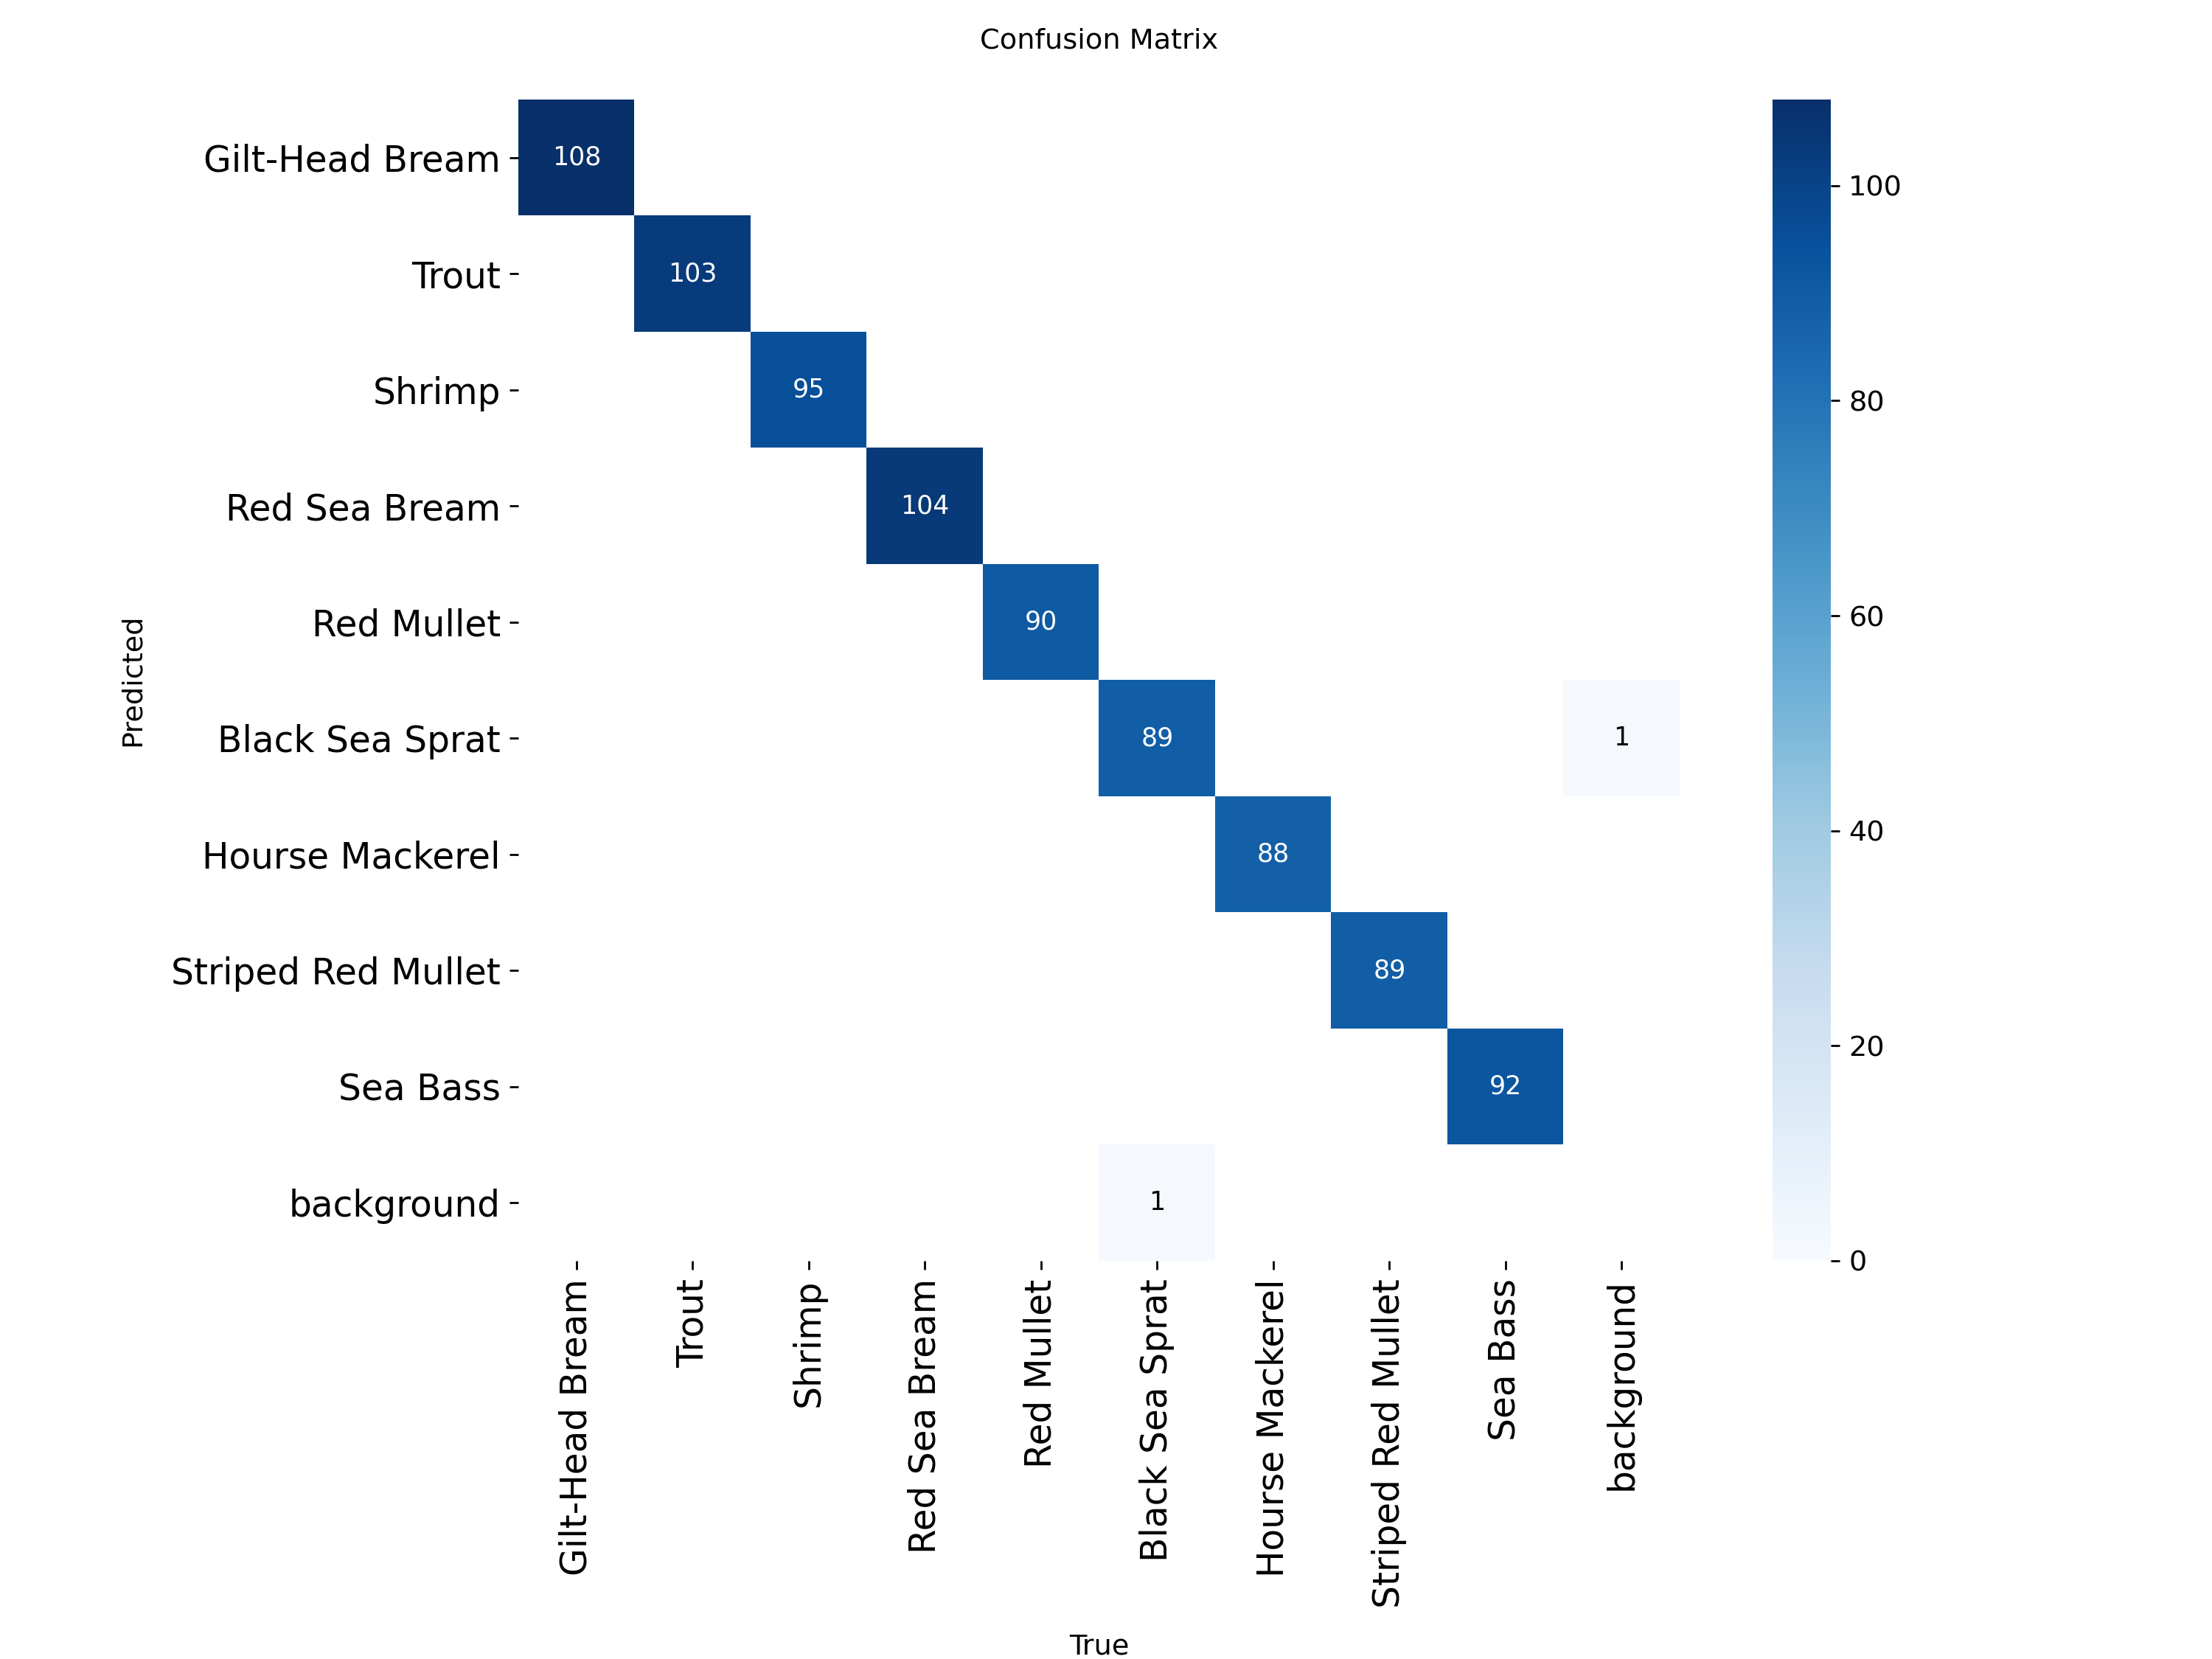


--- Training Results (Loss & mAP) ---


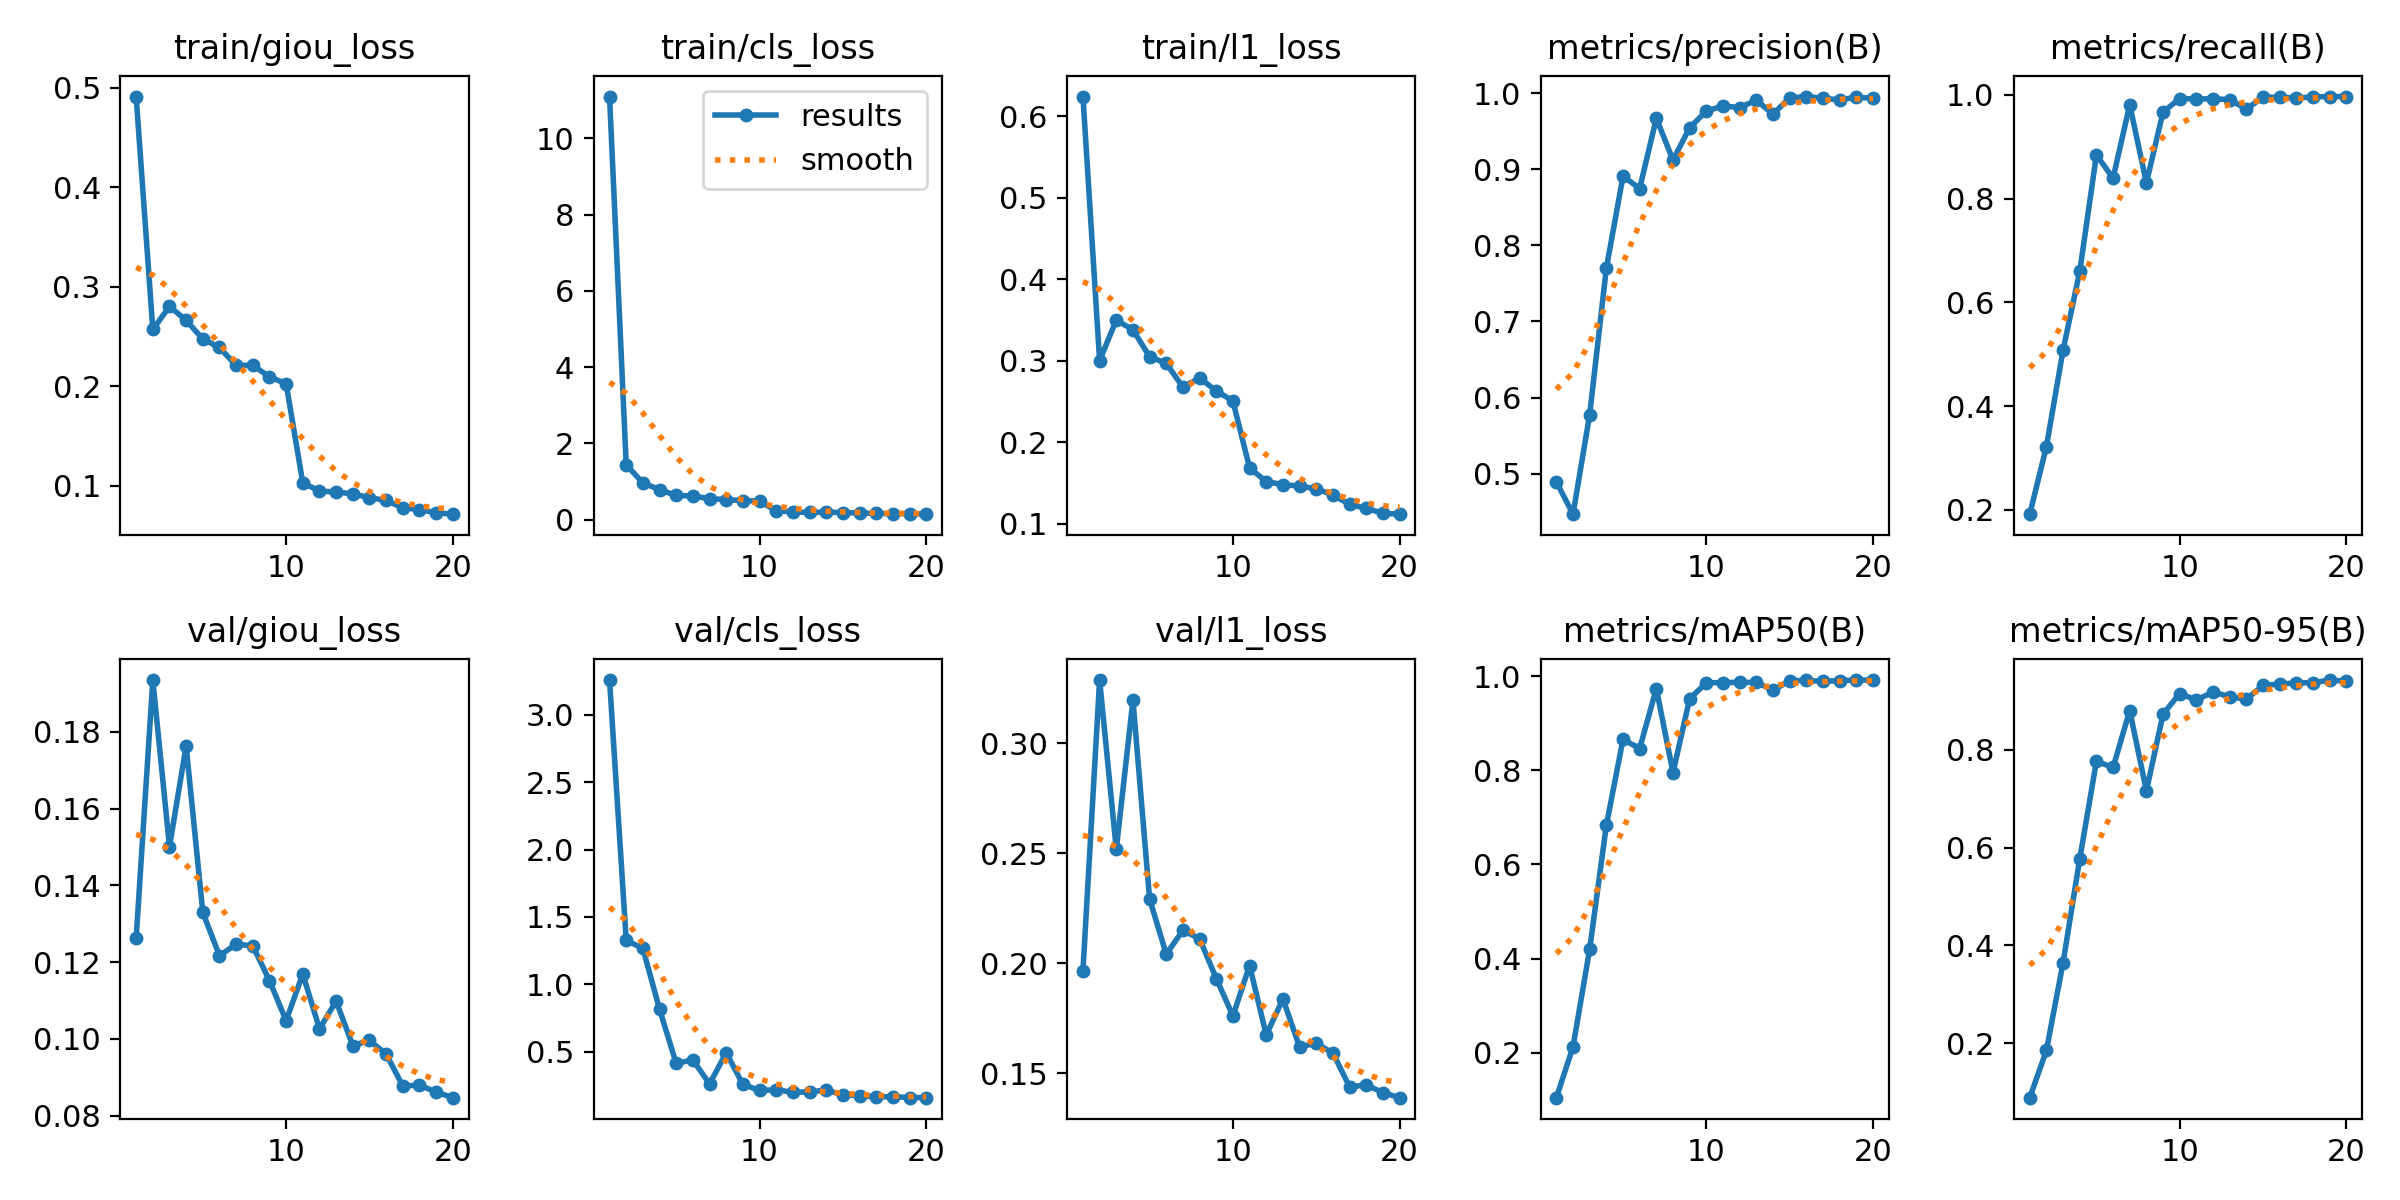

In [8]:
import os
import glob
from IPython.display import Image, display

# 1. Define the base name you used in model.train()
base_name = 'fish_rtdetr_run'

# 2. Find the latest run directory automatically
# This searches runs/detect/ for any folder starting with 'fish_rtdetr_run'
search_pattern = os.path.join("runs", "detect", f"{base_name}*")
all_runs = glob.glob(search_pattern)

if all_runs:
    # Find the folder with the most recent timestamp
    latest_run = max(all_runs, key=os.path.getmtime)
    print(f"✅ Found latest run: {latest_run}")

    # 3. Display the plots
    print("\n--- Confusion Matrix ---")
    display(Image(filename=os.path.join(latest_run, 'confusion_matrix.png')))


    print("\n--- Training Results (Loss & mAP) ---")
    display(Image(filename=os.path.join(latest_run, 'results.png')))


image 1/1 /content/yolo_dataset/images/test/00422.png: 640x640 1 Gilt-Head Bream, 61.8ms
Speed: 2.5ms preprocess, 61.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_dataset/images/test/00422.png: 640x640 1 Gilt-Head Bream, 57.9ms
Speed: 3.5ms preprocess, 57.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Inference time: 80.03 ms


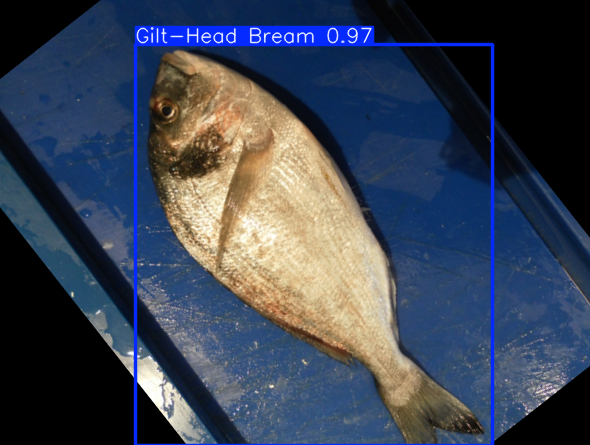

In [15]:
import time
test_img_path = os.path.join(images_dir, 'test', os.listdir(os.path.join(images_dir, 'test'))[0])

# Warm-up
model.predict(test_img_path)

# Measure inference time
start = time.time()
results = model.predict(test_img_path)
end = time.time()

inference_time = (end - start) * 1000   # convert to ms
print(f"Inference time: {inference_time:.2f} ms")

# Display result
for result in results:
    result.show()


image 1/1 /content/yolo_dataset/images/test/00755.png: 640x640 1 Striped Red Mullet, 59.0ms
Speed: 2.4ms preprocess, 59.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_dataset/images/test/00755.png: 640x640 1 Striped Red Mullet, 58.9ms
Speed: 2.3ms preprocess, 58.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
Inference time: 77.09 ms


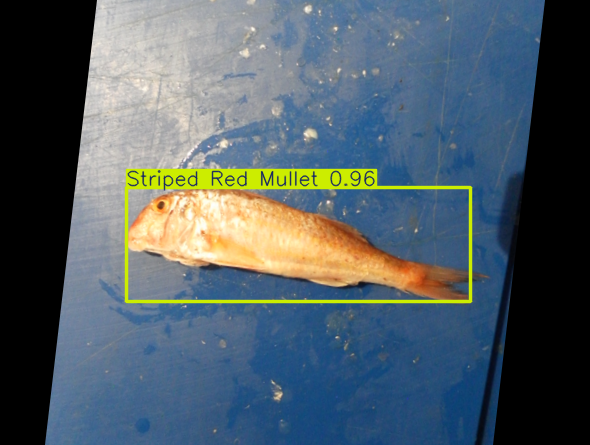

In [14]:
test_img_path = os.path.join(images_dir, 'test', os.listdir(os.path.join(images_dir, 'test'))[500])

# Warm-up
model.predict(test_img_path)

# Measure inference time
start = time.time()
results = model.predict(test_img_path)
end = time.time()

inference_time = (end - start) * 1000   # convert to ms
print(f"Inference time: {inference_time:.2f} ms")

# Display result
for result in results:
    result.show()